# Predictions on different data quality

## Parameters and model

In [1]:
import sys
sys.path.append('..')

from util.graphs import plot_series
from timeseries.timeseries import StockMarketSeries
from timeseries.enums import SeriesColumn, DeviationSource
from predictions.model import PredictionModel

company_name = "Facebook"
time_series_start = "2017-01-03"
time_series_values = 300
column = SeriesColumn.CLOSE
stock = StockMarketSeries(company_name, time_series_start, time_series_values,
                           weights={SeriesColumn.OPEN: 0.2,
                                    SeriesColumn.CLOSE: 0.2,
                                    SeriesColumn.ADJ_CLOSE: 0.25,
                                    SeriesColumn.HIGH: 0.15,
                                    SeriesColumn.LOW: 0.15,
                                    SeriesColumn.VOLUME: 0.05})

## Data - one price column

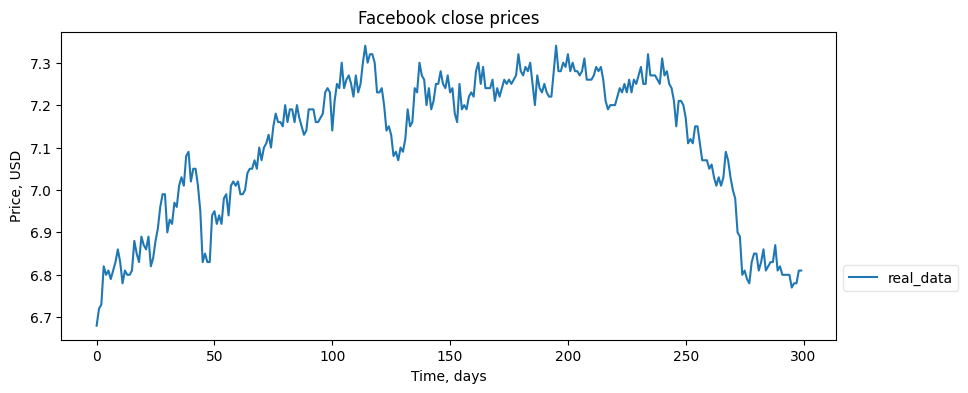

In [2]:
plot_series(stock, "close prices", real_data=stock.real_series[SeriesColumn.CLOSE])

## Predictions parameters

In [3]:
prediction_start = 280
iterations = 5

model = PredictionModel(stock, prediction_start, column, iterations=iterations)

## Statistical methods

In [4]:
from normal.arima import ManualArima, AutoArimaSF

arima_type = AutoArimaSF

C:\Users\Maciek\AppData\Local\Programs\Python\Python39\lib\site-packages\statsforecast\core.py:21: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## AR(p)

In [5]:
arima = model.configure_model(arima_type, p=5, q=0)

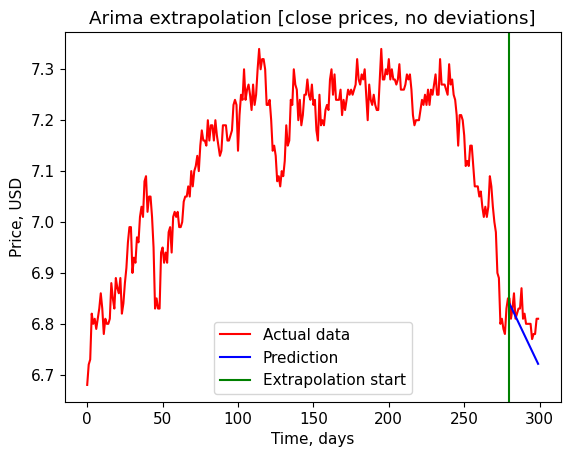

In [6]:
%%capture --no-stdout --no-display
arima.plot_prediction(source=DeviationSource.NONE)

In [7]:
%%capture --no-stdout --no-display
arima.compute_statistics_set()

KeyboardInterrupt: 

## ARIMA(p,d,q)

In [8]:
arima = model.configure_model(arima_type, p=4, q=4)

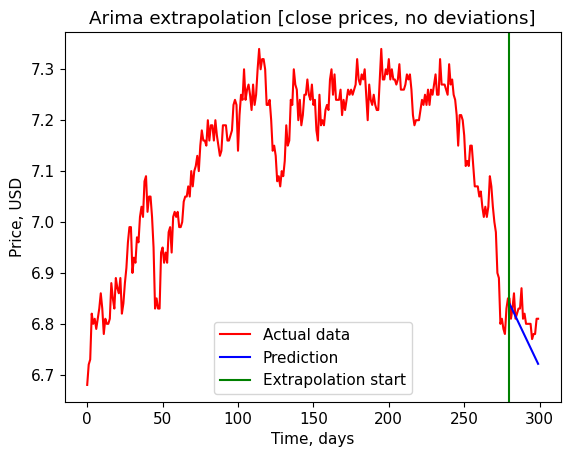

In [9]:
%%capture --no-stdout --no-display
arima.plot_prediction(source=DeviationSource.NONE)

In [10]:
%%capture --no-stdout --no-display
arima.compute_statistics_set()

Statistics [Facebook stock, close price, 5 iterations]

   Deviation Scale Mitigation Time [ms] Time SD M. time  RMSE   MAE   MAPE MAPE SD
0          -     -          N     78.12   12.07     0.0  0.04  0.04   0.54     0.0
1          N     S          N     72.18     8.6     0.0  0.21  0.21   3.12     0.0
2          N     S          Y     97.25    17.1   31.25  0.19  0.19   2.83     0.0
3          N     M          N     72.14    6.67     0.0  0.29  0.29    4.2     0.0
4          N     M          Y    226.97    5.59   31.25  0.22  0.21    3.1     0.0
5          N     H          N    172.67    0.26     0.0  3.81  3.78  55.44     0.0
6          N     H          Y    263.39   15.28   36.75  2.03  2.03  29.73     0.0
7          I     S          N     66.02    7.05     0.0   0.1  0.09   1.36     0.0
8          I     S          Y     68.99    8.57    0.35  0.04  0.04   0.53     0.0
9          I     M          N     80.64    2.98     0.0  0.38  0.37   5.39     0.0
10         I     M          Y  

## XGBoost

In [11]:
from normal.ml import XGBoost

xgboost = model.configure_model(XGBoost, optimize=False)

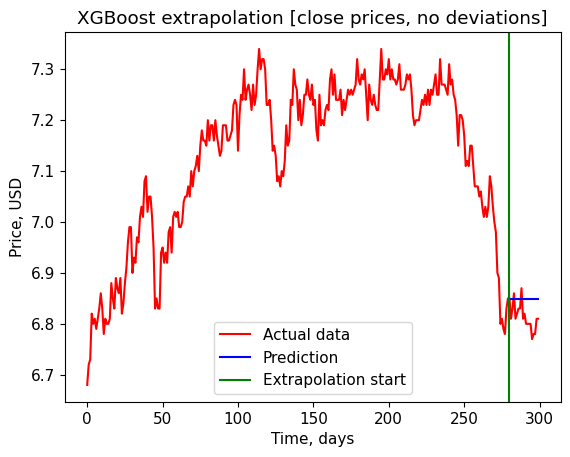

In [12]:
xgboost.plot_prediction(source=DeviationSource.NONE)

In [13]:
%%capture --no-stdout --no-display
xgboost.compute_statistics_set()

Statistics [Facebook stock, close price, 5 iterations]

   Deviation Scale Mitigation Time [ms] Time SD M. time  RMSE   MAE   MAPE MAPE SD
0          -     -          N      43.9    7.08     0.0  0.04  0.04   0.55     0.0
1          N     S          N     58.41    6.17     0.0  0.21  0.21   3.06     0.0
2          N     S          Y     40.94    6.64   31.25  0.19  0.19   2.75     0.0
3          N     M          N     66.79    14.1     0.0  0.51  0.51   7.54     0.0
4          N     M          Y      60.5    17.5   31.25  0.03  0.03   0.44     0.0
5          N     H          N     63.03   16.54     0.0  5.19  5.19  76.15     0.0
6          N     H          Y     54.57    8.03   36.75  1.61  1.61  23.68     0.0
7          I     S          N     40.78    6.84     0.0  0.06  0.05   0.73     0.0
8          I     S          Y     46.52   10.34    0.35  0.04  0.04   0.55     0.0
9          I     M          N     40.05     9.0     0.0  0.16  0.12   1.75     0.0
10         I     M          Y  

## Reservoir computing

In [14]:
from predictions.normal.ml import Reservoir

reservoir = model.configure_model(Reservoir)

In [15]:
reservoir.plot_prediction(source=DeviationSource.NONE)

_LinAlgError: linalg.svd: The algorithm failed to converge because the input matrix is ill-conditioned or has too many repeated singular values (error code: 24).

In [ ]:
%%capture --no-stdout --no-display
reservoir.compute_statistics_set()